# Stack Overflow

## Introduction 

In the second part of this assignment, you will choose to create and analyze time series of creation dates of Stack Overflow questions, or Stack Overflow answers. You need to choose only one of the two, but please mention clearly what kind of time series you created. This assignment is to be completed **INDIVIDUALLY** and is due on **October 6 at 5pm**.

As stated above, you need to create time series of Stack Overflow questions, or answers using their creation dates. In order to do so you should use the information derived from Homework 1.1. Note that the focus of this homework is not on data collection, but on data analysis and interpretation so do not worry if you did not collect all data in the previous homework.

You are going to analyze users. If you selected to create time series of questions take the top 100 users with the most question posts, while if you created time series of answers take the top 100 users with the highest answer scores. For each user, your time series will be the number of questions (for questions), or the score value (for answers) posted by that user at some frequency. You may choose to sample your data each week, each month, on a certain day of the week or at a certain hours in a day depending on what trend you are hoping to find in the data. For example, if you choose to analyze users asking questions and sample during different hours of the day, your hypothesis could be that some users ask more questions during night hours because they are students, while others are more active during day time because they work in industry.   

Compare the time series using one of the methods discussed in class. In a few paragraphs, write down what you were hoping to find in the data (your hypothesis), what timeseries you created, what method you chose and why. Providing us with novel, or more than one hypotheses/analyses will give you extra credit. **(20 pts)**

You may find the [pandas.DataFrame.resample](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) module helpful.

In [322]:
import xml.etree.ElementTree as etree
import time
import sys
import csv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import seaborn as sns
from datetime import datetime


# Using the same csv outputfrom homework 1.1
df = pd.read_csv('hw2.csv', encoding = "ISO-8859-1")

In [334]:
# This block here is to convert the strings in the date to a datetime index inside the same dataframe
df['CreationDate'] = df['CreationDate'].map(lambda x: pd.to_datetime(x))

I want to see the users with the accumlated top 100 answers and sample by every 3 hours. I am curious as to when the answers are being submitted. I suspect that as the people who answer and answer correctly/well are experts in their respective fields. As such I expect these users to be either industry experts, mods, or employed by stackexchange. As such they are most likely to be active during day hours, probably 9 A.M to 6 P.M is where I'd expect to see the highest frequency of posts, where they would post from being bored in their work day. Alternatively these people answer questions recreationally/as a hobby(which I can't imagine but to each their own). I would expect a higher frequency after the work hours in that case, so 6 P.M to 12 A.M. Of course, we have no way of knowing what time zone the poster is living in, so what I will be looking for is to see if the sum of scores is centered about a certain time period
 
So to do this I created time series for each user in the top 100 scores, resampled them by 3 hour increments, summed it through all days (so to analayze by day). Then I concatenated them into one large matrix of samples x features. Samples are the users, features are the summed 3 hour bins. I then made a heatmap of the pairwise distance between users in this matrix. I decided to use pairwise distance to see how similar the users are to one another on the basis of all its features. So a large distance will tell us that the two users don't post near the same time of day, which a short distance shows the users are active near the same time. This wound up showing thata large percentage of the users are very similar to one another, which supports my hypothesis that they tend to be active around the same time periods of the day.


In [616]:
# This gets me the top 100 Scores for ANSWERS
dfnoQ = df.get(df.Type != 'Q')
pd.options.mode.chained_assignment = None  # default='warn'
dfnoQ['Score'] = pd.to_numeric(dfnoQ.Score, errors='coerce').fillna(0).astype(np.int64)
dfsumscore = dfnoQ.groupby('OwnerUserId',as_index=False).agg({'Id': 'first',     #summing for the score column if the userid column is a duplicate
                                                'CreationDate': 'first',
                                                'Tags': 'first',
                                                'ViewCount': 'first',
                                                'Score':sum,
                                                'Type': 'first'}).reset_index(drop=True)

results = dfsumscore.nlargest(100,'Score')
results.index = np.arange(0,len(results))

# I want to create subset dataframes for each of the users in the top 100 scores, then sort them based on time
userdic = {}
bins = '3H'
for user in results['OwnerUserId']:
    userdic[user] = df.loc[df['OwnerUserId'] == user]
    userdic[user] = userdic[user].sort_values(['CreationDate'])
    userdic[user]['Score'] = pd.to_numeric(userdic[user]['Score'],errors='coerce')
    # Below here is where we reindex so we can convert the date to proper datetimeindex
    # then we resample for 3 hours bins
    userdic[user].set_index('CreationDate')
    userdic[user] = userdic[user].reset_index().set_index('CreationDate').Score.resample(bins).mean()
    userdic[user] = userdic[user].fillna(0)  #put 0's in for NaN returns

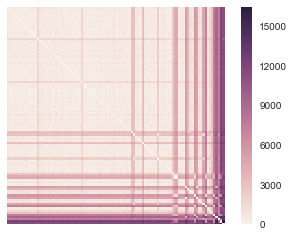

In [557]:
# Now for the fun part, lets first test our initial hypothesis and see when these top posts were most active
ThreeH = {}

for user in userdic:
    ThreeH[user] = userdic[user].groupby(userdic[user].index - userdic[user].index.normalize()).sum()
    

ThreeH['100297'] = ThreeH['100297'].iloc[:,0]# For some reason the first key in the dictionary saved as a dataframe while
# the rest didn't. Can't figure out why for the life of me

array = np.empty([0,8])
for user in ThreeH:
    array = np.vstack(((np.asarray(list(ThreeH[user]))),array))
    
%matplotlib inline
pdistance = metrics.pairwise.pairwise_distances(array)
_ = sns.heatmap(pdistance, xticklabels=False, yticklabels=False, linewidths=0, square=True,cbar=True)


Plot the 2 most similar timeseries in one graph, and plot the 2 most different time series in another graph. Label your axes. **(5 pts)**

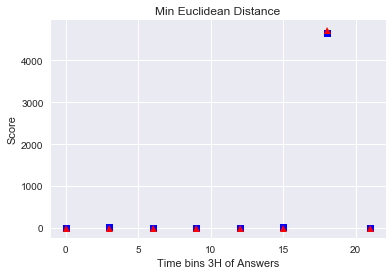

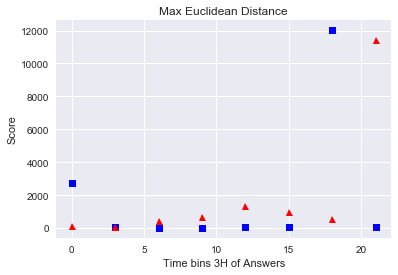

In [620]:
# These should get me the row of the user in the pairwise distance, which should be the same values as the row in the "array" function made earlier
maxdist1 = np.where(pdistance == np.max(pdistance[np.nonzero(pdistance)]))[0][0]    
mindist1 = np.where(pdistance == np.min(pdistance[np.nonzero(pdistance)]))[0][0]    
maxdist2 = np.where(pdistance == np.max(pdistance[np.nonzero(pdistance)]))[1][0]    
mindist2 = np.where(pdistance == np.min(pdistance[np.nonzero(pdistance)]))[1][0]  

# Find the users who's pairwise distance is the max and min respectively
for user in ThreeH:
    if np.array_equal(ThreeH[user],(array[maxdist1])):
        locmax1 = user
    if np.array_equal(ThreeH[user],(array[maxdist2])):
        locmax2 = user

for user in ThreeH:
    if np.array_equal(ThreeH[user],(array[mindist1])):
        locmin1 = user 
    if np.array_equal(ThreeH[user],(array[mindist2])):
        locmin2 = user

# Now we can plot the two max dist users and 2 min distance users together
timeaxis = np.arange(0,24,3)
plt.plot(timeaxis, np.asarray(ThreeH[locmin1]), 'bs', timeaxis, np.asarray(ThreeH[locmin2]), 'r^')
plt.ylabel('Score')
plt.xlabel('Time bins {} of Answers'.format(bins))
plt.title('Min Euclidean Distance')
plt.show()

plt.plot(timeaxis, np.asarray(ThreeH[locmax1]), 'bs', timeaxis, np.asarray(ThreeH[locmax2]), 'r^')
plt.ylabel('Score')
plt.xlabel('Time bins {} of Answers'.format(bins))
plt.title('Max Euclidean Distance')
plt.show()

What are your interpretation/conclusions from the above plotting comparisons? **(5 pts)**

It's very clear to see the minimum distance between two users based on their time of day posting is represented very well in this graph. I can conclude that both these users are active around the same time of day at ~18:00:00UTC. We can also see that in the max plot the two user are active at different times of the day. What's interesting is that you can see the red triangle user (locmax2) seems to be active all throughout the day, then activity spikes at ~21:00:00UTC before I assume they go to sleep. In any case, you can see that the two users have uncannily close time bins where they are active, but are desynchronized. However, noting the score axis, you can see how the two users arrive at the maximum because of the raw max score they each have as well. I am sure a normalized score may tell more about users who are truely active at very different times of the day, because as you can see, both the users have a period of relative inactivity overlapping one another.

Choose a different distance/similarity metric and repeat the same time series analysis. **(5 pts)**

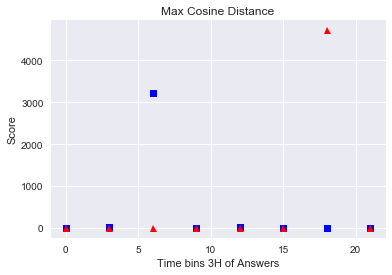

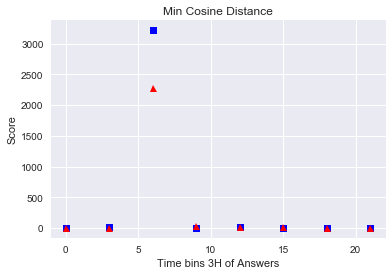

In [646]:
# Cosine distance
cdistance = metrics.pairwise.cosine_similarity(array)
cdistance = cdistance.round(4)
# These should get me the row of the user in the pairwise distance, which should be the same values as the row in the "array" function made earlier
maxdist1 = np.where(cdistance == np.max(cdistance[np.nonzero(cdistance != 1)]))[0][0]    
mindist1 = np.where(cdistance == np.min(cdistance[np.nonzero(cdistance != 1)]))[0][0]    
maxdist2 = np.where(cdistance == np.max(cdistance[np.nonzero(cdistance != 1)]))[1][0]    
mindist2 = np.where(cdistance == np.min(cdistance[np.nonzero(cdistance != 1)]))[1][0]  

# Find the users who's pairwise distance is the max and min respectively
for user in ThreeH:
    if np.array_equal(ThreeH[user],(array[maxdist1])):
        locmax1 = user
    if np.array_equal(ThreeH[user],(array[maxdist2])):
        locmax2 = user

for user in ThreeH:
    if np.array_equal(ThreeH[user],(array[mindist1])):
        locmin1 = user 
    if np.array_equal(ThreeH[user],(array[mindist2])):
        locmin2 = user

# Now we can plot the two max dist users and 2 min distance users together
# This is really the max distance since cosine of 0 = 1, and an angle of 0 means the two vectors are pointing in the same direction
# so they should be similar, so we need to reverse it
timeaxis = np.arange(0,24,3)
plt.plot(timeaxis, np.asarray(ThreeH[locmin1]), 'bs', timeaxis, np.asarray(ThreeH[locmin2]), 'r^')
plt.ylabel('Score')
plt.xlabel('Time bins {} of Answers'.format(bins))
plt.title('Max Cosine Distance')
plt.show()

#This is really the min distance
plt.plot(timeaxis, np.asarray(ThreeH[locmax1]), 'bs', timeaxis, np.asarray(ThreeH[locmax2]), 'r^')
plt.ylabel('Score')
plt.xlabel('Time bins {} of Answers'.format(bins))
plt.title('Min Cosine Distance')
plt.show()

Compare the two different metrics you used and report any observations. Why did you select the specific metrics? Which do you think performed better based on the results you were expecting and why? **(5 pts)**

I used euclidean distance at first because I wanted to see the raw distance of score between two users, figuring that it would tell me that the users are active at different times of the day. I then saw the raw score value had a heavy influence in the euclidean distance, and likely will for manhattan distance. Therefore I wanted use a distance metric that does not account for the magnitude, as that would better reflect when the users are active. I think the cosine performed better, but not perfectly. The cosine distance calculation lead to some issues as I would get a value greater than 1 for distance (which is impossible, for unscaled cosines). In anycase, rounding to work around that, we can still see that the max distance plot is similar, if not worse than the euclidean distance as there seems to be more overlap, however the two users clearly are very active in different times of the day, likewise you can see that the min distance are active at the same time of the day. The loss of magnitude certainly helps find more "positives" that fit the type of data we're looking for.
